# Static Web Scraping for Sports Data
In this notebook, we will use several Python libraries to scrape static data from the Premier League's official site. More specifically, we will scrape data about the current standings in the league, creating a dataset that would allow us to proceed down the data science pipeline.

Below is an image of the site we are going to scrape. Essentially, we will interact with the site to get the data shown in the following table into a format in Python that we can operate on. (Note that only the top of the table is shown, and that Chelsea isn't there)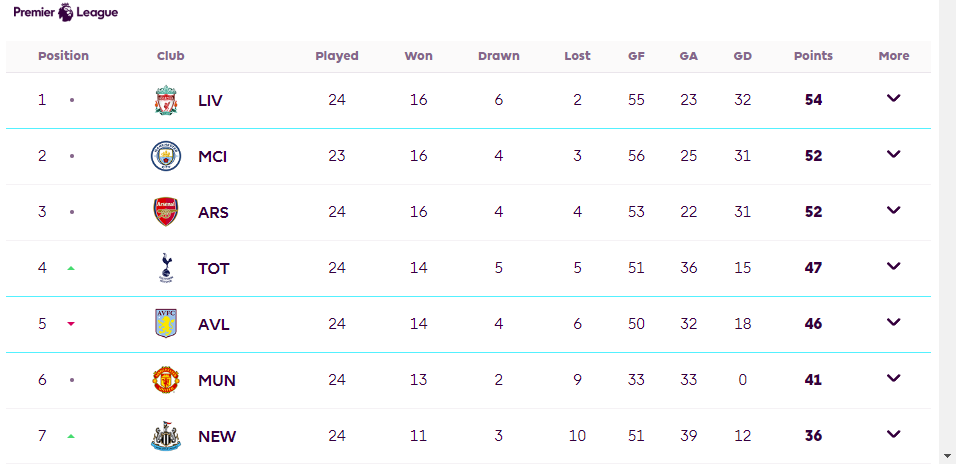

Before we start, we will import the relevant Python libraries, requests, Beautiful Soup 4, and Pandas. This is done below.

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas

First, we will use the Requests library to make an HTTP get request to the link that has the data we are trying to scrape. This will return the HTML content of the page, which we can parse through in later steps.

Note how we separate base_url the tables_path, when the url we are going to visit is a concatenation of the two (https://www.premierleague.com/). In a scenario where we have many different urls to visit that all use a single base url, this can be a simple way to keep track of and store these urls, avoiding redundancy from storing the base_url with every possible path.

In [ ]:
# URL to request
base_url = "https://www.premierleague.com/"
tables_path = "tables"

In [ ]:
# make get request
response = requests.get(base_url + tables_path)

We can check the status code below. A status code 200 means that the request was successful; in our case, it means that we were successfully able to access the web page and pull its HTML content. We cam use an assertion to formally verify this. We will get an assertion error if the request fails (i.e., it is not 200). This can help us catch problems early on.

In [ ]:
assert response.status_code == 200

print(f"Response okay? {response.ok}")
print(f"Status code: {response.status_code}")

Response okay? True
Status code: 200


We check the content type of the response below. As we can see, we get the HTML of the page returned in the response.

In [ ]:
print(response.headers['Content-Type'])

text/html;charset=utf-8


We can set up a BeautifulSoup4 object passing in html.parser to parse the HTML response.

In [ ]:
soup = bs(response.content, "html.parser")

Here, we create a list for each column. This is where we will place data that we parse, and will allow us to easily pass it into a Pandas dataframe object later on.

In [ ]:
club = []
position = []
prev_position = []
played = []
won = []
drawn = []
lost = []
gf = []
ga = []
gd = []
points = []

col_names = ["club", "position", "prev_position", "played", "won", "drawn", "lost", "gf", "ga", "gd", "points"]

Let's use our BeautifulSoup object to explore a few ways of retrieving data, and then we can scrape the data we need.

The first way is with the find_all() function in BeautifulSoup4. This allows us to find HTML elements in the DOM according to element types and other information associated with these elements. Some of these include regex, lists that specify multiple items to match with, or even using a user-defined function. Read more about those here: https://beautiful-soup-4.readthedocs.io/en/latest/#searching-the-tree

In [ ]:
# Finding all a tags in the html using find_all then getting their links
a_tags = soup.find_all("a")

# Print out the text and the link for the first three
for tag in a_tags[:3]:
  print(f"Text: {tag.text.strip()}, {tag['href'].strip()}")
  print()

Text: Skip to main navigation, #mainNav

Text: Skip to main content, #mainContent

Text: Arsenal

Arsenal, http://www.arsenal.com?utm_source=premier-league-website&utm_campaign=website&utm_medium=link



Below we define a function that takes in a tag and returns whether the tag has the href attribute defined and if it does not have an id defined. When we pass this into the find_all() function, we can find all the elements that match this criteria. We can list the number of elements that match this below.

In [ ]:
# Function to return if an element has both an href defined and an id defined
def link_with_no_id(tag):
    return tag.has_attr('href') and not tag.has_attr('id')

print(len((soup.find_all(link_with_no_id))))

1061


Another method we can use is with the select() function in BeautifulSoup4. This is similar to find_all() in terms of functionality, but it instead uses the CSS selector defined in the HTML document. Both can be useful; find_all() is generally faster, while select() can be useful for complex relationships between elements.

In [ ]:
# Another method: using select to get all a tags where the parent is a div
css_selector = "div > a"
selector_res = soup.select(css_selector)

for tag in selector_res[:3]:
  print(f"Text: {tag.text.strip()}, {tag['href'].strip()}")
  print()

Text: , https://www.premierleague.com/home

Text: Liverpool, /clubs/10/Liverpool/overview

Text: LIV




3 -1




BUR, /match/93554



Next, we will gather our data. We will first attempt to find all of the club names. From the chart, we know there are 20 teams in the Premier League. In the browser, we can inspect element and see that the name is in a span with a specific combination of CSS classes. We can use the class_ argument in find_all to try to find matching elements.

In [ ]:
club_name_long = [i.text for i in soup.find_all("span", class_="league-table__team-name league-table__team-name--long long")]
print(f"Number of elements with team names: {len(club_name_long)}")


First attempt number of elements with team names: 72


Is the above expected? No. We expect 20 teams, not 72. Therefore, we need to be more specific, or try a new method. Here, we will try a different method using selectors. Using the document again, we can find that the parent table has a class .isPL that we can use in conjunction with the classes from the previous attempt as shown below.

In [ ]:
selector = ".isPL .league-table__team .league-table__team-name--long"
club_name_long = [i.text for i in soup.select(selector)]
print(f"Second attempt number of elements with team names: {len(club_name_long)}")
print("Using selector: ", club_name_long)

Second attempt number of elements with team names: 20
Using selector:  ['Liverpool', 'Manchester City', 'Arsenal', 'Tottenham Hotspur', 'Aston Villa', 'Manchester United', 'Newcastle United', 'West Ham United', 'Brighton and Hove Albion', 'Chelsea', 'Wolverhampton Wanderers', 'Fulham', 'Bournemouth', 'Brentford', 'Crystal Palace', 'Nottingham Forest', 'Luton Town', 'Everton', 'Burnley', 'Sheffield United']


The above was what we were looking for, yielding 20 elements. Note the difference between the approaches used: in find_all(), the class we specify is for a specific element, whereas in select(), our structure represents a hierarchical structure (for example, class isPL that is a parent of league-table__team. etc.).

Another way we can find the elements is simply taking the index of the elements we need from a more general term. Therefore, we can use the first example and take the first 20 with indexing, as we can show with some print statements that these are the elements we are looking for.

In [ ]:
club_name_long_index = [i.text for i in soup.find_all("span", class_="league-table__team-name league-table__team-name--long long")][:20]
print(f"Third attempt number of elements with team names: {len(club_name_long_index)}")
print("Using find_all() with indexing: ", club_name_long_index)

Third attempt number of elements with team names: 20
Using find_all() with indexing:  ['Liverpool', 'Manchester City', 'Arsenal', 'Tottenham Hotspur', 'Aston Villa', 'Manchester United', 'Newcastle United', 'West Ham United', 'Brighton and Hove Albion', 'Chelsea', 'Wolverhampton Wanderers', 'Fulham', 'Bournemouth', 'Brentford', 'Crystal Palace', 'Nottingham Forest', 'Luton Town', 'Everton', 'Burnley', 'Sheffield United']


As we can see, the third method is correct as well. However, the selector method is preferred because the element structure in the find_all() example is clearly used a lot. There is a chance that the page could restructure and suddenly, the first 20 elements aren't what we want. Page restructuring is a potential problem for all methods, but if we are using a general selector that could be added in other places in the DOM in future site updates, our code is more likely to break in future additions.

Below, we will go through and gather the rest of the data we need. Since we will be using generally the same method to gather each column of data, we can use a function called table_extract to avoid redundancies. It takes in a subclass that is some sort of descendant from .isPL, a class that the main table has. It then uses a similar method to how we gathered club_names_long to gather data. It also takes in a data type parameter data_type that allows us to cast the data to a particular type and return it in the proper format.

In [ ]:
def table_extract(selector: str, data_type: type = str) -> list:
  new_selector = ".isPL " + selector
  data = [data_type(i.text.strip()) for i in soup.select(new_selector)]
  return data

In [ ]:
prev_position = table_extract(".league-table__pos .league-table__result-highlight", int)
played = table_extract("tr > td:nth-child(3)", int)
won = table_extract("tr > td:nth-child(4)", int)
drawn = table_extract("tr > td:nth-child(5)", int)
lost = table_extract("tr > td:nth-child(6)", int)
gf = table_extract("tr > td:nth-child(7)", int)
ga = table_extract("tr > td:nth-child(8)", int)
gd = table_extract("tr > td:nth-child(9)", int)
points = table_extract("tr > td:nth-child(10)", int)

Now that we have our data in lists, we can use the pandas library to add the data to a dataframe, a convenient and useful way of storing data for efficient operations.

In [ ]:
import pandas as pd

club = club_name_long
position = [i for i in range(1, 21)]

cols = [club, position, prev_position, played, won, drawn, lost, gf, ga, gd, points]

data = dict()
for i in range(len(col_names)):
    data[col_names[i]] = cols[i]

df = pd.DataFrame(data=data)
print(df)

                        club  position  prev_position  played  won  drawn  \
0                  Liverpool         1              1      24   16      6   
1            Manchester City         2              2      23   16      4   
2                    Arsenal         3              3      24   16      4   
3          Tottenham Hotspur         4              5      24   14      5   
4                Aston Villa         5              4      24   14      4   
5          Manchester United         6              6      24   13      2   
6           Newcastle United         7              9      24   11      3   
7            West Ham United         8              7      24   10      6   
8   Brighton and Hove Albion         9              8      24    9      8   
9                    Chelsea        10             11      24   10      4   
10   Wolverhampton Wanderers        11             10      24    9      5   
11                    Fulham        12             13      24    8      5   

As we can see, we now have our data stored in a dataframe that can be used in further steps in the data science pipeline.

For more information about the libraries used here, visit the docs:

Python libraries discussed:
- requests: https://requests.readthedocs.io/en/latest/
- Beautiful Soup 4: https://beautiful-soup-4.readthedocs.io/en/latest/
- pandas: https://pandas.pydata.org/docs/

Other useful links:
- Document Object Model (DOM) https://developer.mozilla.org/en-US/docs/Web/API/Document_Object_Model
- HTTP: https://www.ibm.com/docs/en/cics-ts/5.3?topic=protocol-http-requests